In [58]:
%matplotlib inline
import numpy as np
import time
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
from matplotlib import cm
plt.rcParams.update(newparams)

import scipy as sci

## a)

In [59]:
#We create a new object-class for IBVP
class BVP(object): 
    def __init__(self, x_a=0, x_b=1, y_a=0, y_b=1, ux_0=0, ux_1=0, uy_0=0, uy_1=0, RHS=0):
        
        self.ux_0 = ux_0       # left boundary condition
        self.ux_1 = ux_1       # right boundary condition
        self.uy_0 = uy_0       # Upper boundary condition
        self.uy_1 = uy_1       # Lower boundary condition
        
        self.x_a = x_a         # left side boundry for x
        self.y_a = y_a         # left side boundry for y
        self.x_b = x_b         # right side boundry for x
        self.y_b = y_b         # right side boundry for y
        
        self.RHS = RHS        # right hand side of equation
        

In [60]:
#Reuse code from lecture notes
#Plotting function 
def plot_solution(x, y, U, txt='Solution'):
    
    fig, ax = plt.subplots(figsize = (10,10), subplot_kw={"projection": "3d"})
    Y, X = np.meshgrid(x,y)
    ax.plot_wireframe(X, Y, U)
    ax.plot_surface(X,Y, U, cmap='hot')
    ax.view_init(azim=30)              # Rotate the figure
    plt.xlabel('Y')
    plt.ylabel('x')
    plt.title(txt);

In [61]:
#Initial condition

def ux_0(x,y):      #Y=0
    return np.sin(np.pi*x)*np.sin(np.pi*y)
    
def ux_1(x,y):      #Y=1
    return np.sin(np.pi*x)*np.sin(np.pi*y)

def uy_0(x,y):      #X=0
    return np.sin(np.pi*x)*np.sin(np.pi*y)

def uy_1(x,y):      #X=1
    return np.sin(np.pi*x)*np.sin(np.pi*y)

def RHS(x,y,a,h,k):     # Right hand side
    r=k/h
    return -(np.pi**2*a*r*np.cos(np.pi*x)*np.cos(np.pi*y)-np.pi**2*(a+1)*np.sin(np.pi*x)*np.sin(np.pi*y)-np.pi**2*r**2*np.sin(np.pi*x)*np.sin(np.pi*y))


def analyticSol(x,y): 
    return x**2*np.cos(5*y)

def RHS_2(x,y,a,h,k): #Right hand side
    r=k/h
    return -(2*(a+1)*np.cos(5*y) - 20*r*x*np.sin(5*y) - 25*r**2*x**2*np.cos(5*y))

In [62]:
#Reuse code from lecture notes

def grid(BVP,M,N): 
    
    #Input: Initial boundry problem, number of nodes in x and y direction
    #Output: Stepsize in x and y direction, 2 d array of interior gridpoints, shape of solution
        
    x = np.linspace(BVP.x_a, BVP.x_b, M+1,endpoint=True)
    y = np.linspace(BVP.y_a, BVP.y_b, N+1,endpoint=True)
    
    # these ones are valid only for this case
    # in general the radius of the smallest inscribed
    # circle should be taken
    h=x[1]-x[0] # x typical space-step
    k=y[1]-y[0] # y typical space-step
    
    # full coorindate array of INTERNAL points
    shape = [len(x[1:-1]), len(y[1:-1])]
    x, y = np.meshgrid(x[1:-1], y[1:-1])

    # reshaping so that I have columnwise vectors
    # with all the x and y coordinates. In practice, THIS passage already
    # re-order the array in a vector that follows the numbering explained
    # in the figure above
    x, y = x.flatten(), y.flatten()
    
    # array with coordinates
    coord = np.zeros((x.size,2))
    coord[:,0]=x
    coord[:,1]=y
    
    
    return h, k, coord, shape

In [63]:
#Define a function that creates a tridiagonal matrix
def tridiag(a,h,k, N, M):    
    
    A = np.zeros(((N-2)*(M-2), (N-2)*(M-2)))        #Define an 2D array we can create our matrix in
    A=sci.sparse.lil_matrix(((N-2)*(M-2), (N-2)*(M-2)))
    x = np.ones((N-2)*(M-2))                        #Define an 1D array with same length as our matrix with only ones
     
    x_L=np.copy(x[1:])                              #Slice the array to fit the lower diagonal
    x_L[M-3::M-2]=0                                 #Remove every M-2 element to create adjust for the boundry gridpoints
    
    x_LL=np.copy(x[:-(M-1)])                        #Slice the array to fit the m-1 lower diagonal
    x_LL[M-3::M-2]=0                                #Remove every M-2 element to create adjust for the boundry gridpoints
    
    x_U=np.copy(x[1:])                              #Slice the array to fit the upper diagonal                   
    x_U[M-3::M-2]=0                                 #Remove every M-2 element to create adjust for the boundry gridpoints
    
    x_UU=np.copy(x[:-(M-1)])                        #Slice the array to fit the m-1 upper diagonal
    x_UU[M-3::M-2]=0                                #Remove every M-2 element to create adjust for the boundry gridpoints
    
    r=np.sqrt(k/h)
    #Use np.diag to create the A matrix
    A=np.diag(x*(2*a/h**2+2/(h**2)),0) + np.diag(x_U*(-a)/h**2,1) + np.diag(x_L*(-a)/h**2,-1) + np.diag(x_UU*(-1)/(h**2),(M-1)) + np.diag(x_LL*(-1)/(h**2),(-M+1))
    return A

In [56]:
def solver(BVP, a, M=10, N=10):
    # Input: 
    #       BVP: Boundry value problem
    #       M, N: number of grid intervals in the x- and t directions
    #       a: constant
    
    # Output: 
    #       x_grid, y_grid: the gridpoints in the x- and t- directions 
    #       U: An array with the numerical solution for all grid points
    
    
    h,k,coord,shape = grid(BVP,M,N)                    #Use existing function to get a 2 d array of interiorpoints 
    U=np.zeros((N+1,M+1))                              #Define a 2 d array to save the solution in
    
    x_grid = np.linspace(BVP.x_a, BVP.x_b, M+1)        #Creating x grid
    y_grid = np.linspace(BVP.y_a, BVP.y_b, N+1)        #Creating y grid
    
    
    
    x_0_values=BVP.ux_0(x_grid,BVP.y_a)                #Defining x-valuess at y=0
    x_1_values=BVP.ux_1(x_grid,BVP.y_b)                #Defining x-valuess at y=1
    y_0_values=BVP.uy_0(BVP.x_a,y_grid)                #Defining y-valuess at x=0
    y_1_values=BVP.uy_1(BVP.x_b,y_grid)                #Defining y-valuess at y=1
    
                                                       #Plot boundry points into the solution
    U[0,:]=x_0_values                                  
    U[-1,:]=x_1_values
    U[:,0]=y_0_values
    U[:,-1]=y_1_values                                
    
    A=tridiag(a,h,k,N+1,M+1)                          #Use tridiag function to get A_h matrix
    plt.spy(A)                                        #Plot the solver matrix
    
    

    g_vec=np.zeros((M-1)*(N-1))                       #Define a vector for the "boundry adjustments"
    
    for i in range(len(g_vec)):                       #iterating through all interiorpoints to add boundry points
        
        
        if(i%(M-1)==0):                               #Adding right side boundry
            g_vec[i]+=-a*y_0_values[i//(M-1)+1] - y_0_values[i//(M-1)]
            
        elif((i+1)%(M-1)==0):                         #Adding left side boundry
            g_vec[i]+=-a*y_1_values[i//(M-1)+1] - y_1_values[i//(M-1)+2]
        
        if(i>0 and i<(M-1)):                          #Adding south boundry
            g_vec[i]+=-x_0_values[i]
            
        elif((M-1)*(N-2) <= i <= (M-1)*(N-1)-2):      #Adding north boundry
            g_vec[i]+=-x_1_values[i%(M-1)+2]
    
    f_vec=BVP.RHS(coord[:,0],coord[:,1],a,h,k)        #Define a vector for the right hand side array
    U_vec=sci.sparse.linalg.spsolve(A,f_vec-g_vec/h**2)         #Solve the matrix problem
    U_array = np.reshape(U_vec, (N-1, M-1))           #Reshape the 1d solution array to a 2d array for interiorpoints
    
    U[1:-1,1:-1]=U_array                              #Fill in the solution vector
    #print(h,k)
    return U, x_grid, y_grid


[[1600. -400.    0. ...    0.    0.    0.]
 [-400. 1600. -400. ...    0.    0.    0.]
 [   0. -400. 1600. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ... 1600. -400.    0.]
 [   0.    0.    0. ... -400. 1600. -400.]
 [   0.    0.    0. ...    0. -400. 1600.]]


AttributeError: module 'scipy.sparse' has no attribute 'linalg'

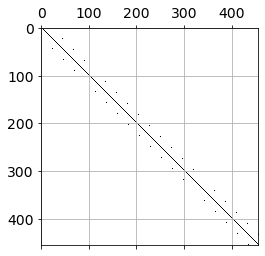

In [57]:
#Creating BVP's
a=1
test_BVP=BVP(0, 1, 0, 1, ux_0, ux_1, uy_0, uy_1, RHS)
test_BVP_2=BVP(0, 1, 0, 1, analyticSol,analyticSol,analyticSol,analyticSol,RHS_2)

#Create a nummerical and an analytical solution 
U, x_grid, y_grid=solver(test_BVP_2, a, M=20,N=25)
X, Y = np.meshgrid(x_grid,y_grid)
solution=analyticSol(X,Y)

#Plotting the solutions and the error
plot_solution(x_grid,y_grid,solution, "Analytical")
plot_solution(x_grid,y_grid,U, "Nummerical")
plot_solution(x_grid,y_grid,(solution-U), "Error")
print(f"Max error: {np.max(np.abs(solution-U))} ")

## c)

In [35]:
#Reuse convergence-tester from lecture-code. Modify it to fit our impl
def convergence_test_space(u_analytic, test_problem, solver=solver):
    a=2
    P = 5
    Hconv = np.zeros(P)
    Kconv = np.zeros(P)
    Econv = np.zeros(P)
    M = 8
    for p in range(P):
        N=int(M/2)
        U, x, y = solver(test_problem, a, M, N)
        X, Y = np.meshgrid(x,y)
        Eh = u_analytic(X,Y)-U
        Hconv[p] = (x[1]-x[0])
        Kconv[p] = (y[1]-y[0])
        Econv[p] = np.max(np.abs(Eh))
        M = 2*M

    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Kconv, Econv, order



,h,k,Error,Rate
0,0.12500000,0.25000000,0.05581583,0.00000000
1,0.06250000,0.12500000,0.01324744,2.07496097
2,0.03125000,0.06250000,0.00326929,2.01866599
3,0.01562500,0.03125000,0.00081467,2.00468027
4,0.00781250,0.01562500,0.00020370,1.99975157


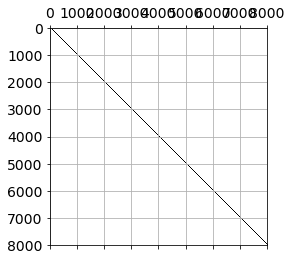

In [38]:
H, K, E, p = convergence_test_space(analyticSol, test_BVP_2, solver)
#H, E, p = convergence_test_space(uy_1, test_BVP, solver)


import pandas as pd #To format the output of the notebook.  
Rate=np.zeros(np.size(E))
Rate[1:]=np.log10(E[1:]/E[:-1])/np.log10(H[1:]/H[:-1])
pd.options.display.float_format = '{:.8f}'.format
df = pd.DataFrame(data={'h': H,'k':K, 'Error': E , 'Rate':Rate}) 
df

987.9983322591472


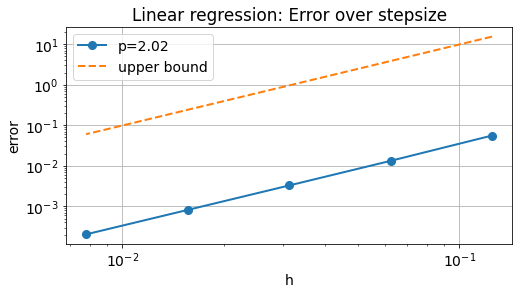

In [45]:
constant=1/4*(50*np.pi**2/4 + 250*np.pi**3/6 + 625*np.pi**4/24)
print(constant)

plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.loglog(H,constant*(H**2),'--',label='upper bound')
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.title("Linear regression: Error over stepsize")
plt.legend();

## d)

We are asked to now investigate the problem with a bad direction. We want to solve the problem for an irrational $r$.
We want to solve this by using the fattening of the boundry. Since our new $r$ is irational, we can no longer adjust our upper boundry for y to be equal $1$. We are asked to define $h$ and $k$ the following way
$$
\begin{align*}
h&=\frac{1}{M} \\
k&=|r|h =\frac{1}{N}\\
\end{align*}
$$

We can combine this with our prior definitions to find the value for N
$$
\begin{align*}
N=&\frac{1}{|r|h} \\
\implies N=&\frac{M}{|r|}
\end{align*}
$$

Since $r$ is an irational number, we know that $N$ will be irational, which means we can only find an N such that we get arbitrary close to $y=1$, but never exactly $y=1$. We want $N \dot k \approx  1^+$, so we always get a value above $Y=1$ as our upper boundry.


In [12]:
def analyticSol_d(x,y): 
    return x**2*np.cos(5*y)

def RHS_d(x,y,a,h,k): #Right hand side
    r=k/h
    return -(2*(a+1)*np.cos(5*y) - 20*r*x*np.sin(5*y) - 25*r**2*x**2*np.cos(5*y))

In [13]:
def solver_d(BVP, a, r, M=10, value=False):
    # Input: 
    #       BVP: Boundry value problem
    #       M, N: number of grid intervals in the x- and t directions
    #       a: constant
    
    # Output: 
    #       x_grid, y_grid: the gridpoints in the x- and t- directions 
    #       U: An array with the numerical solution for all grid points
    
    N=int(np.ceil(M/np.abs(r)))                         #Use the derived formula for y_maks with the np.ceil funtion to round the value up                 
    BVP.y_b=np.abs(r)*(1/M)*N                           #Redefine our y_maks value 
    
    h,k,coord,shape = grid(BVP,M,N)                     #Use existing function to get a 2 d array of interiorpoints 
    U=np.zeros((N+1,M+1))                               #Define a 2 d array to save the solution in
    
    x_grid = np.linspace(BVP.x_a, BVP.x_b, M+1)         #Creating x_grid
    y_grid = np.linspace(BVP.y_a, BVP.y_b, N+1)         #Creating y_grid
    
    if(value):                                          #If we solve with methode 2
        y_grid[-1]=1
    
    x_0_values=BVP.ux_0(x_grid,BVP.y_a)                 #Defining x-valuess at y=0
    y_0_values=BVP.uy_0(BVP.x_a,y_grid)                 #Defining y-valuess at x=0
    y_1_values=BVP.uy_1(BVP.x_b,y_grid)                 #Defining y-valuess at x=1
    x_1_values=BVP.ux_1(x_grid,BVP.y_b)                 #Defining x-valuess at y=y_maks
    x_1_values_mod=BVP.ux_1(x_grid,1)                   #Define x-values at y=1  
    
                                                        #Add boundry points into the solution    
    U[:,0]=y_0_values                                 
    U[:,-1]=y_1_values
    U[0,:]=x_0_values
    U[-1,:]=x_1_values_mod                              #Use values for y=1  

    A=tridiag(a,h,k,N+1,M+1)                            #Creating an A_h matrix
    #plt.spy(A)
    
    

    g_vec=np.zeros((M-1)*(N-1))                         #Define a vector for the "boundry adjustments"
    
    for i in range(len(g_vec)):                         #iterating through all interiorpoints to add boundry points
        
        if(i%(M-1)==0):                                 #Adding right side boundry
            g_vec[i]+=-a*y_0_values[i//(M-1)+1] - y_0_values[i//(M-1)]
            
        elif((i+1)%(M-1)==0):                           #Adding left side boundry
            g_vec[i]+=-a*y_1_values[i//(M-1)+1] - y_1_values[i//(M-1)+2] 
        
        if(i>0 and i<(M-1)):                            #Adding south boundry
            g_vec[i]+=-x_0_values[i]
            
        elif((M-1)*(N-2) <= i <= (M-1)*(N-1)-2):        #Adding north boundry
            if(value):
                 g_vec[i]+=-x_1_values_mod[i%(M-1)+2]
            else:
                g_vec[i]+=-x_1_values[i%(M-1)+2]
    

    f_vec=BVP.RHS(coord[:,0],coord[:,1],a,h,k)          #Define a vector for the right hand side array
    U_vec=np.linalg.solve(A,f_vec-g_vec/(h**2))         #Solve the matrix problem
    U_array = np.reshape(U_vec, (N-1, M-1))             #Reshape the 1d solution array to a 2d array for interiorpoints
    
    U[1:-1,1:-1]=U_array                                #Fill in the solution vector
    
    if(not value):                                         #If we use methode 1
        y_grid[-1]=1                                    #Create the grid so that the y_maks = 1
    
    return U, x_grid, y_grid


Max error: 0.0011618701586426639 


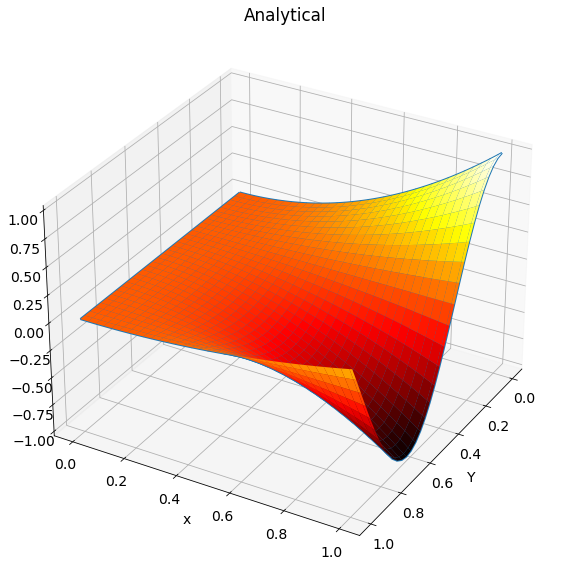

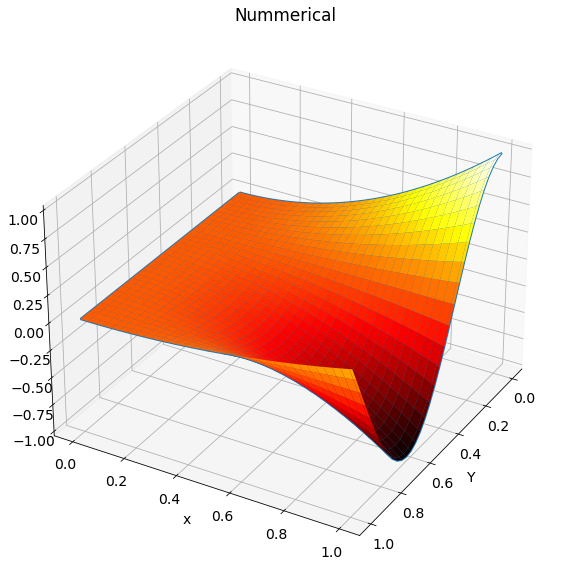

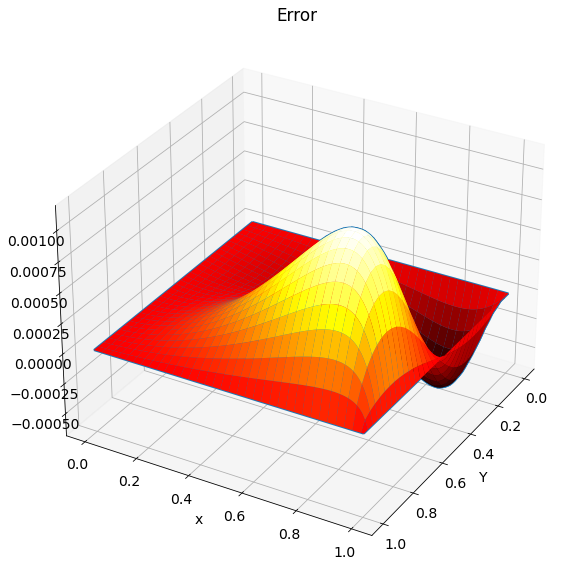

In [14]:
a=2
r=np.pi

test_BVP_d=BVP(0, 1, 0, 1, analyticSol_d,analyticSol_d,analyticSol_d,analyticSol_d,RHS_d)
U_d, x_grid, y_grid = solver_d(test_BVP_d, a, r, M=100)

X, Y = np.meshgrid(x_grid,y_grid)
solution=analyticSol_d(X,Y)



plot_solution(x_grid,y_grid,solution, "Analytical")
plot_solution(x_grid,y_grid,U_d, "Nummerical")
plot_solution(x_grid[:],y_grid,(solution-U_d), "Error")
print(f"Max error: {np.max(np.abs(solution-U_d))} ")

In [15]:
#Reuse convergence-tester from lecture-code 

def convergence_test_space_d(u_analytic, test_problem, solver=solver):
    r=np.pi
    a=2
    P = 60
    Hconv = np.zeros(P)
    Kconv = np.zeros(P)
    Econv = np.zeros(P)
    for p in range(P):
        U, x, y = solver(test_problem, a,r, 20+p)
        X, Y = np.meshgrid(x,y)
        Eh = u_analytic(X,Y)-U
        Hconv[p] = (x[3]-x[2])
        Kconv[p] = (y[3]-y[2])
        Econv[p] = np.max(np.abs(Eh))

    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Kconv, Econv, order


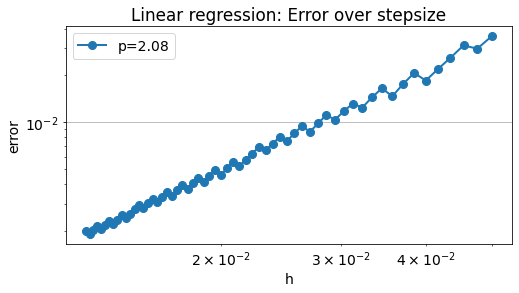

In [16]:
test_BVP_d=BVP(0, 1, 0, 1, analyticSol_d,analyticSol_d,analyticSol_d,analyticSol_d,RHS_d)
H_d, K_d, E_d, p_d = convergence_test_space_d(analyticSol_d, test_BVP_d, solver_d)

plt.loglog(H_d,E_d,'o-', label='p={:.2f}'.format(p_d))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.title("Linear regression: Error over stepsize")
plt.legend();

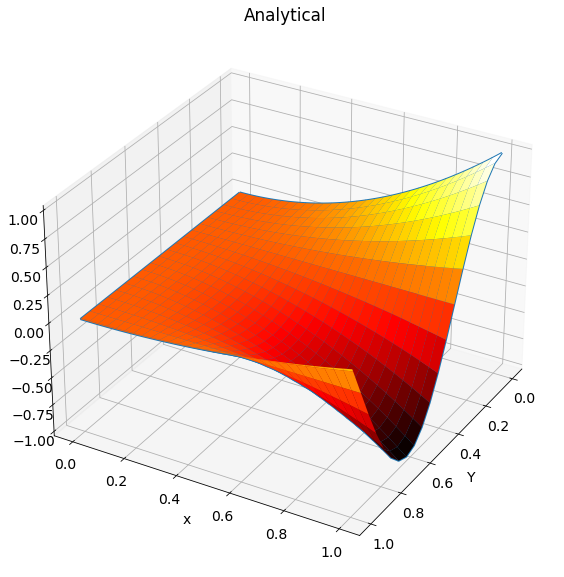

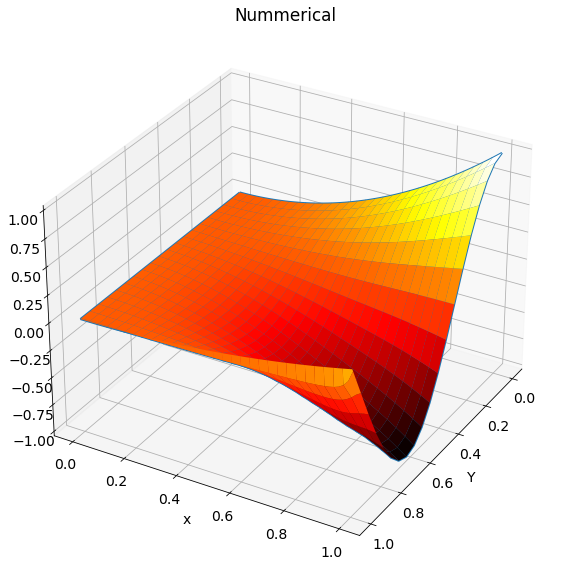

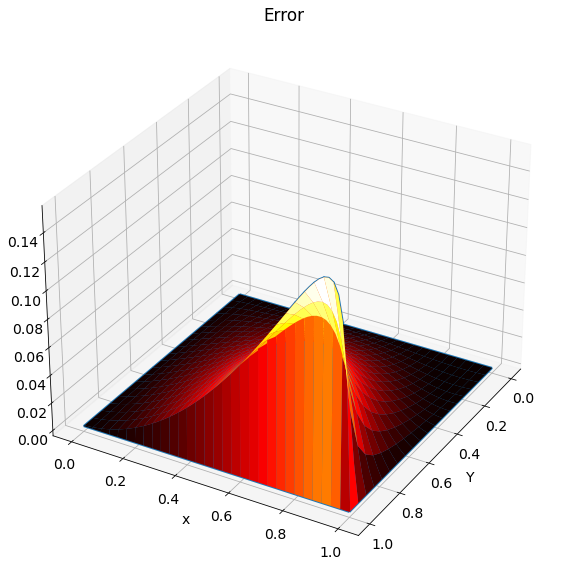

In [17]:
a=2
r=np.pi

test_BVP_d_2=BVP(0, 1, 0, 1, analyticSol_d,analyticSol_d,analyticSol_d,analyticSol_d,RHS_d)
U_d, x_grid, y_grid = solver_d(test_BVP_d, a, r, M=60, value=True)

X, Y = np.meshgrid(x_grid,y_grid)
solution=analyticSol_d(X,Y)



plot_solution(x_grid,y_grid,solution, "Analytical")
plot_solution(x_grid,y_grid,U_d, "Nummerical")
plot_solution(x_grid[:],y_grid,(solution[:,:]-U_d[:,:]), "Error")

In [18]:
#Reuse convergence-tester from lecture-code 

def convergence_test_space_d(u_analytic, test_problem,P, solver=solver):
    a=2
    Hconv = np.zeros(P)
    Kconv = np.zeros(P)
    Econv = np.zeros(P)
    Yconv = np.zeros(P)
    for p in range(P):
        U, x, y = solver(test_problem, a,r, 8+p, value=True)
        X, Y = np.meshgrid(x,y)
        Eh = u_analytic(X,Y)-U
        Hconv[p] = (x[3]-x[2])
        Kconv[p] = (y[3]-y[2])
        Econv[p] = np.max(np.abs(Eh))
        #if(p>P-10):
            #print(P-p)


    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Kconv, Econv , order




In [19]:
test_BVP_d=BVP(0, 1, 0, 1, analyticSol_d,analyticSol_d,analyticSol_d,analyticSol_d,RHS_d)
H_d, K_d, E_d, p_d = convergence_test_space_d(analyticSol_d, test_BVP_d, 50, solver_d)
#H, E, p = convergence_test_space(uy_1, test_BVP, solver)

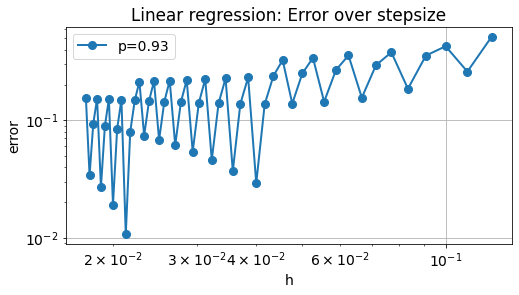

In [20]:
plt.loglog(H_d,E_d,'o-', label='p={:.2f}'.format(p_d))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.title("Linear regression: Error over stepsize")
plt.legend();


In [21]:
minP=30
maxP=90
array_pvalues=np.linspace(minP,maxP,maxP-minP,endpoint=False)
array_order=np.zeros(maxP-minP)
for i in range(minP,maxP):
    if(i%5==0):
        print(i)
    H_d, K_d, E_d, p_d = convergence_test_space_d(analyticSol_d, test_BVP_d, i, solver_d)
    array_order[i-minP]=p_d

30
35
40
45
50
55
60
65
70
75
80
85


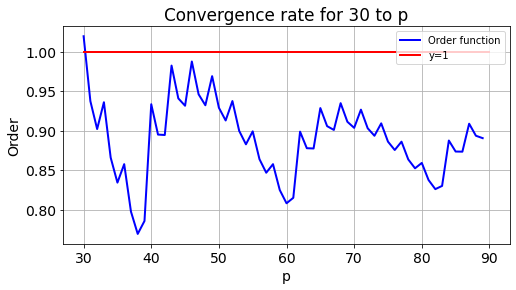

In [22]:
plt.figure()
plt.title(f"Convergence rate for {minP} to p")
plt.plot(array_pvalues,array_order,"b", label = "Order function")
plt.xlabel("p")
plt.ylabel("Order")
plt.plot((minP,maxP),(1,1), "r", label="y=1")
plt.legend(fontsize="10", loc="upper right")
plt.show()

In [23]:
def boundry_function(x):
    return 1/2*(np.cos(np.pi*x)+1)

def inverse_boundry_function(y):
    return np.arccos(2*y-1)/np.pi

In [24]:
N=100
M=100

def grid_check_function(M,N):
    y_grid = np.linspace(0,1,N+1)
    x_grid = np.linspace(0,1,M+1)

    B=np.zeros((N+1,M+1))
    element_array=np.zeros(N+1)
    
    for i in range(N+1):
        B[N-i]=(x_grid<=inverse_boundry_function(y_grid[i]))
        element_array[N-i]=np.sum(B[N-i])
    sum_rows=(np.sum(B))
    
    return B, sum_rows, element_array

print(grid_check_function(14,14)[0])


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [25]:
#Define a function that creates a tridiagonal matrix
def tridiag_2(M,N):
    grid, element_sum, element_array=grid_check_function(M,N)
    
    edge_elements = np.zeros(N)
    
    for i in range(N):
        if(i==0):
            edge_elements[N-i-1]=(element_array[N-i]-element_array[N-i-1])
            
        elif(element_array[N-i]-element_array[N-i-1]==0):
            edge_elements[N-i-1]=element_array[N-i]-element_array[N-i-1]+1
        else:
            edge_elements[N-i-1]=element_array[N-i]-element_array[N-i-1]
            

    x=0
    y=N
    diag_array=np.zeros(int(element_sum+sum(edge_elements)))
    for i in range(int(element_sum+sum(edge_elements))):
        #print(x,y)
        if(y==N):
            diag_array[i]=1
        elif(x==0):
            diag_array[i]=1
        if(x==M):
            x=0
            y=y-1
            print("End of line")
        elif(grid[y][x+1]==0):
            x=0
            y=y-1
            i=i+1
            print("End of 1's")
        else:
            x=x+1
    return diag_array
print(tridiag_2(14,14))

End of line
End of 1's
End of 1's
End of 1's
End of 1's
End of 1's
End of 1's
End of 1's
End of 1's
End of 1's
End of 1's
End of 1's
End of 1's
End of 1's
End of 1's
End of line
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
